## Automatic Musical Meter Detection
#### from [1] Gainza, M. (2009) Automatic Musical Meter detection. IEEE International Conference on Acoustics, Speech and Signal Processing, Taipei, Taiwan, 2009.

In this notebook we aim to reproduce the algorithm presented by Gainza, M in 2009. This algorithm is an evolution of the previous paper by the same author written in 2007, where a method for time signature estimation by using multi-resolution similarity matrix is developed.

In this case the author presents a methodology based on the generation of a beat similarity matrix. This provides information on the similarity of every pair of beats of the music piece. The idea is to use the similar rhythmic patterns along the track to find the structure of the piece. The proposed algorithm also uses dynamic programming to track similarities even when small changes in tempo occur. 

The author states that this approach proves to be very effective, but as we will discuss later on, in our case the results don't show the same effectiveness.



   #### Import necessary modules

In [48]:
import essentia.standard as estd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist, squareform
import statistics as stats
from scipy.signal import find_peaks
import csv
import pandas as pd
import xml.etree.ElementTree as ET


#### Initialise global variables

In [49]:
## var init
frame_size = 1024
hop_size = 512
fft_size = 1024

# Dynamic Programming vars
R = 30
C = 30

#path to folder with data set files
path_to_data_set = '../mp3/'

# file used as example
path = 'blues-12-8.wav'


#### Get audio vector
The audio files from the data set are sampled at 16kHz, but latter in our algorithm we will use a function from Essentia to get the beat position and this requires a an audio of 44.1kHz. For that reason in this function we resample the audio.

In [50]:
def load_audio(path):
    out_fs = 44100
    full_path = path_to_data_set + path
    loader = estd.AudioLoader(filename=full_path)
    downmixer = estd.MonoMixer()
    tempAudioInput, fs, numb_channels, md5, bit_rate, codec = loader()    
    audioInputM = downmixer(tempAudioInput, numb_channels)
    resamp = estd.Resample(inputSampleRate = fs, outputSampleRate = out_fs)
    audioInput = resamp(audioInputM)
    tempo_estimation_algo = estd.PercivalBpmEstimator(sampleRate=int(fs))
    bpm = tempo_estimation_algo(audioInput)
    return audioInput, out_fs

#### Compute the Minum Cost from origin to a point
This function uses Dynamic Programming techniques to calculate in the most efficient way the minimum sum possible from origin to the target cell (m,n) travelling always down, right and diagonally to lower cells.

Ref: https://www.geeksforgeeks.org/min-cost-path-dp-6/

In [51]:
# Dynamic Programming Python implementation of Min Cost Path
def minCost(cost, m, n): 
  
    # Instead of following line, we can use int tc[m+1][n+1] or 
    # dynamically allocate memoery to save space. The following 
    # line is used to keep te program simple and make it working 
    # on all compilers.
    tc = [[0 for x in range(C)] for x in range(R)] 
  
    tc[0][0] = cost[0][0] 
  
    # Initialize first column of total cost(tc) array 
    for i in range(1, m+1): 
        tc[i][0] = tc[i-1][0] + cost[i][0] 
  
    # Initialize first row of tc array 
    for j in range(1, n+1): 
        tc[0][j] = tc[0][j-1] + cost[0][j] 
  
    # Construct rest of the tc array 
    for i in range(1, m+1): 
        for j in range(1, n+1): 
            tc[i][j] = min(tc[i-1][j-1], tc[i-1][j], tc[i][j-1]) + cost[i][j] 
  
    return tc[m][n] 

#### Compute spectrogram
The variables used in this calculation are declared at the initalisation of this notebook.

`frame_size = 1024`

`hop_size = 512`

`fft_size = 1024`

In [52]:
def compute_spectrogram(audioInput, fs):
    ## get necessary Essentia algorithms
    window_algo = estd.Windowing(normalized=True, size = frame_size, type = 'hann')
    fft_algo = estd.FFT(size = fft_size)

    spectrogram = []
    db_spectrogram = []
    cutoff_bin = int(5000*1024/fs)

    for index, frame in enumerate(estd.FrameGenerator(audioInput, frameSize = frame_size, hopSize = hop_size, startFromZero = True)):
        ## spectrogram
        windowed_frame = window_algo(frame)
        mX = abs(fft_algo(windowed_frame))
        mX[mX<np.finfo(float).eps] = np.finfo(float).eps    ## if zeros add epsilon to handle log
        dbX = 20 * np.log10(mX[:cutoff_bin+1])
        spectrogram.append(np.array(mX[:cutoff_bin+1]))
        db_spectrogram.append(np.array(dbX))

    spectrogram = np.array(spectrogram)
    db_spectrogram = np.array(db_spectrogram)
    return spectrogram, db_spectrogram

#### Plot Spectrogram (for visual feedback only)
The following two cells are used only for development purposes. To check that our process is working as expected.

In [53]:
audioInput, fs = load_audio(path)
spectrogram, db_spectrogram = compute_spectrogram(audioInput, fs)

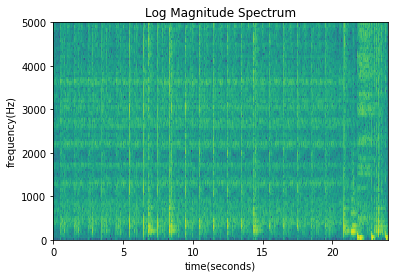

In [54]:
timeAxSec=np.arange(db_spectrogram.shape[0])*hop_size/float(fs)
freqAx_normalized=np.arange(db_spectrogram.shape[1])/float(fft_size)    #Normalized frequency axis
freqAxHz=float(fs)*freqAx_normalized

plt.pcolormesh(timeAxSec,freqAxHz,np.transpose(db_spectrogram))
plt.xlim([0,timeAxSec[-1]])
plt.ylim([0,freqAxHz[-1]])
plt.title('Log Magnitude Spectrum')
plt.ylabel('frequency(Hz)')
plt.xlabel('time(seconds)')
plt.show()

#### Get the frames belonging to beats
This algorithm is based in comparing the frames of every two beats of the track, for this reason the beat detection is needed.

In this case we use Essentia's BeatTrackerDegara algorithm to find the beat positions.

In [55]:
def get_beats_frames(audioInput, fs):
    beatTracker = estd.BeatTrackerDegara()
    beats = beatTracker(audioInput)
    beats_frames = [int(bf) for bf in (beats * fs / hop_size)]
    return beats_frames, beats

#### Get Audio Similarity Matrix
Once the spectrogram is calculated and the beats are found, the next step is to create an Audio Similarity Matrix (ASM) for every two beats.

In this case the author proposes, as a way of improving efficiency, to calculate the similarity between beats using the frames of the detected beat and the neigbours in a range of +/- 8%. So if $T_i$ is the duration of the beat $j_i$, the selected frames for that beat will be $[j_i-T_i, \dots ,j_i, \dots, j_i+T_i]$

The writting of this idea is not very clear in the original paper, and this could be a point of difference with the original algorithm, but after deduction and trial and error of other options, this seems to be the approach stated.

A possibility to consider as futher work would be creating this similarity matrix for all the frames between beats instead of only using the 8% neightbours.

In [56]:
def get_ASM(beats_frames, spectrogram):
    beats_neighbour_spect = {}
    i = 0
    while i <= len(beats_frames)-1:
        if i != len(beats_frames)-1:
            beat_duration = beats_frames[i+1] - beats_frames[i]
        duration_8_percent = int(beat_duration*0.08)
        beats_neighbour_spect[beats_frames[i]] = spectrogram[beats_frames[i]-duration_8_percent:beats_frames[i]+duration_8_percent]
        i += 1

    ASM_dict = {}
    for beat_x in beats_neighbour_spect:
        ASM_dict[beat_x] = {}
        for beat_y in beats_neighbour_spect:
            temp_ASM = cdist(beats_neighbour_spect[beat_x], beats_neighbour_spect[beat_y], metric='euclidean')
            ASM_dict[beat_x][beat_y] = temp_ASM
    return ASM_dict

#### Get Beat Similarity Matrix
Once we have the audio similarity matrix for each pair of beats, we compute a single value for the similarity between each of those pairs by calculating the sum of the minimum cost path for the audio similarity matrix. This value $S$ will be used to build the Beat Similarity Matrix (BSM).

In [57]:
def get_BSM(ASM_dict):
    BSM = []
    counti = 0 
    for beat_frame_i, ASM_beat_dict in ASM_dict.items():
        BSM.append([])
        for beat_frame_j, ASM in ASM_beat_dict.items():
            if ASM.shape == (0,0):
                continue
            BSM[counti].append(minCost(ASM, ASM.shape[0]-1, ASM.shape[1]-1))
        counti += 1
    return BSM


#### Diagonal Processing and Best Meter Candidate Calculation

Once we have the BSM we will process the diagonals to find the best meter candidate. By calculating the mean of the components of each diagonal we will have a representation of the similarity between beats separated by a different number of beats.

$ d_i = mean(diag(BSM_i)) $

Afterwards the results are inverted to have a peak for the at the diagonals with maximum similarity. A factor of 1.5 will be used to enhancen the peaks.

$ d_i = -d_i + max(|d|) $

We will evaluate the bar candidates from 2 to 11. 

Finally a weighted comb filter is used in order to consider multiples of each bar candidate. The function is:

$ T_c = \sum_{p=1}^{lt} \frac{d(p \times c)}{ 1 - \frac{p-1}{lt} }      \quad   c = 2,...,11 $

Once again in the writting of this section there is some ambiguity and the mathematical equations have mistakes, so maybe there could be a point of differentiation with the original algorithm


In [58]:
def get_candidates_list(BSM):
    d = []
    d_inverted = []
    for i, beat in enumerate(BSM):
        d.append(stats.mean(list(np.diagonal(BSM, i))))
        d_inverted.append(-d[i])
    #invert d to have maximums
    d_inverted += max([abs(item) for item in d])
    
    # multiply peaks by 1.5 to accentuate peaks
    d_peaks = find_peaks(d_inverted)[0]
    for i in d_peaks:
        d_inverted[i] *= 1.5
       
    bar_candidates = list(range(2,12))
    lt = math.floor(len(beats)/11)
    tc = []
    for c in bar_candidates:
        t_sum = 0
        for p in range(1, lt+1):
            if p*c >= len(d_inverted):
                continue
            t_sum += (d_inverted[p*c]/(1-((p-1)/lt)))
        tc.append(t_sum)
    return tc, bar_candidates



#### Plot bar candidates function
The highest peak is the best candidate

In [59]:
def plot_tc(tc):
    plt.xticks(list(range(10)), bar_candidates)
    plt.plot(tc)
    plt.show()

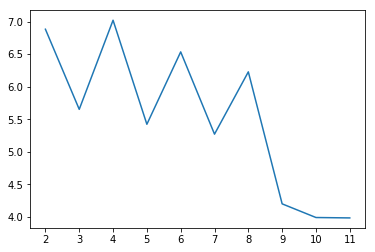

In [60]:
beats_frames, beats = get_beats_frames(audioInput, fs)
ASM_dict = get_ASM(beats_frames, spectrogram)
BSM = get_BSM(ASM_dict)
tc, bar_candidates = get_candidates_list(BSM)
plot_tc(tc)

#### Evaluation of results

In the original paper there is no confidence value estimated. We consider this, one of the main problems with the evaluation process, as there is no indication on how good this algorithm is other than the percentage values of correct estimations from the 3 data sets used.

__Data Set 1__ It is referenced to be from another paper, but the link found in this reference is not active anymore:
* `A. Klapuri, A. Eronen, et al., "Analysis of the meter of acoustic musical signals," IEEE Trans. Speech and Audio Processing, 2004.`

This data set contains 314 songs with duple and cuadruple meters and 6 songs with triple meters. No other explanation of the data set is given.

__Data Set 2__
A second data set of 26 songs in triple meter is built. No other information is given.

__Data Set 3__
A data set with 21 songs with complex meters including 5,7,9 and 11 beat meters "is used". No more information is given.

For each of this data sets a table of "good meter detections" percentages is given, comparing a diferent algorithm using autocorrelation and this algorithm with three different distance methods for the Audio Similarity Matrix calculation. In all of them the proposed algorithm performs better.

References for the autocorrelation algorithm:

* `J. C. Brown, "Determination of the meter of musical scores by autocorrelation," Journal of the Acoustical Society of America, vol. 4, pp. 1953-1957, 1993.`

* `M. Davies and M. D. Plumbley, "Context-dependent beat tracking of musical audio," IEEE Transactions on Audio, Speech and Language Processing, 2007.`

* `S. Dixon, E. Pampalk, et al., "Classification of dance music by periodicity patterns," presented at 4th Int. Conference on Music Information Retrieval, 2003.`


We consider this evaluation methodology to be quite ambiguos and not reproducible.

#### Our evaluation proposal
#### Get Top Candidate and Confidence

Get top candidate meter value. We propose to get a value of the confidence of the best meter value.

The confidence value proposed is calculated as the ratio between the sum of the values of $T_c$ for all the candidates and the value for the top candidate. If the peak for the top candidate is significantly higher than the rest the confidence ratio should be high.

In [61]:
def get_top_candidate(tc):
    return tc.index( max(tc) ) + 2 

def get_confidence_top_candidate(tc):
    return max(tc) / sum(tc)

#### Data Set
We use as data set the MagnaTagATune Dataset.
Ref: 
* `Edith Law, Kris West, Michael Mandel, Mert Bay and J. Stephen Downie (2009). Evaluation of algorithms using games: the case of music annotation. In  Proceedings of the 10th International Conference on Music Information Retrieval (ISMIR)`
http://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset


This data set contains 30s long fragments of tracks. This are annotated by the echonest API with a time signature estimation and it's corresponding confidence. Time signatures can be: 3,4,5 and 7. 

From this data set we select a list of fragments by selecting a number songs from every different possible meter matching a tag. 

We created a list of 24 different tags in order to have a varied collection of music. From each of these tags we select 3 songs for every available time signature.

The resulting collection has 47 songs. 13 with time signature 3, 33 with time signature 4 and 3 with time signature 7.

In [62]:
path_to_csv = '../annotations_final.csv'
path_to_xml = '../mp3_echonest_xml'
pd_annotations = pd.read_csv(path_to_csv, '\t')

def getTrackCollection(tag='rock', num=1, minConfidence=0.8):
    collection = {}
    for i in range(pd_annotations.shape[1]):
        if pd_annotations[tag][i] == 1:
            xml_track = ET.parse(path_to_xml + '/' + pd_annotations['mp3_path'][i] + '.xml').getroot()
            for child in xml_track:
                if float(child.attrib['timeSignatureConfidence']) >= minConfidence:
                    if child.attrib['timeSignature'] not in collection:
                        collection[child.attrib['timeSignature']] = []
                    if len(collection[child.attrib['timeSignature']]) < num:
                        if float(child.attrib['timeSignatureConfidence']) >= minConfidence:
                            collection[child.attrib['timeSignature']].append({'path': pd_annotations['mp3_path'][i],
                                                                          'timeSignatureConfidence': child.attrib['timeSignatureConfidence'],
                                                                          'tempo':child.attrib['tempo']})    
    return collection

4


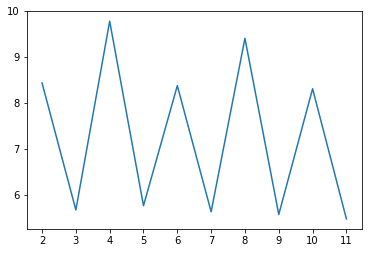

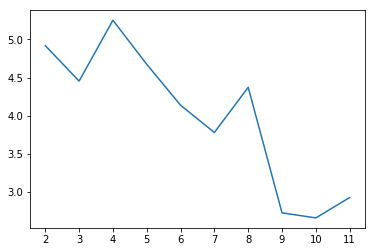

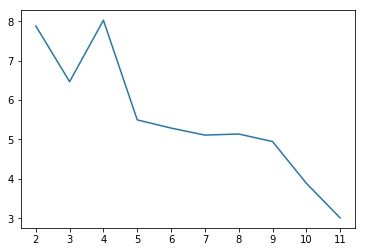

0
7


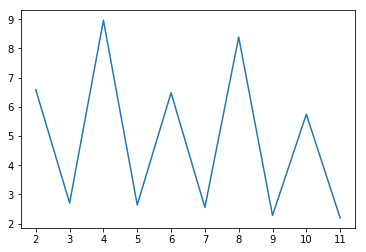

4


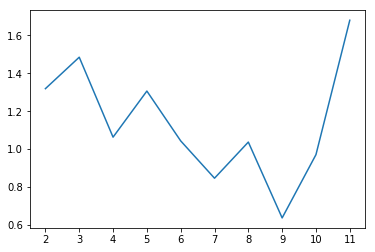

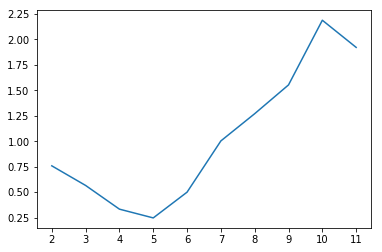

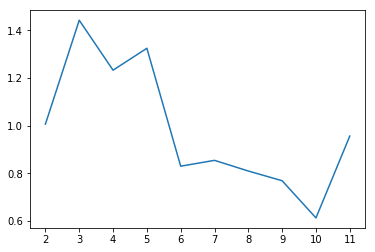

3


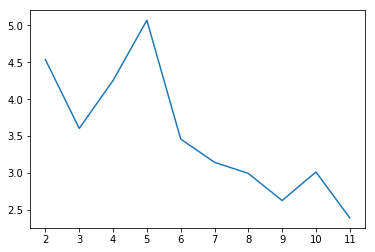

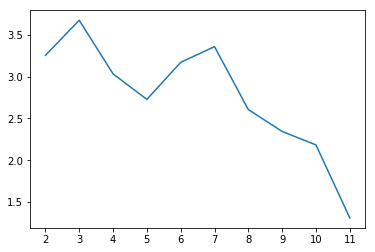

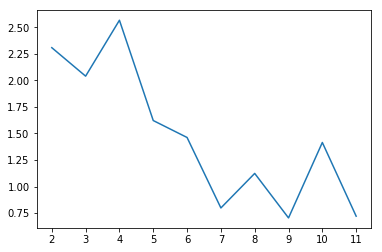

0
7


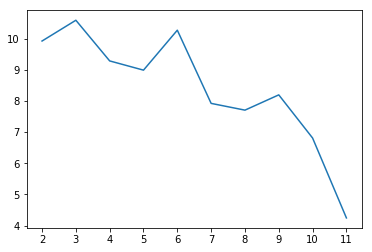

4


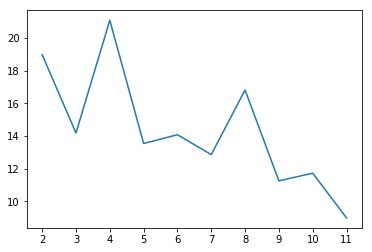

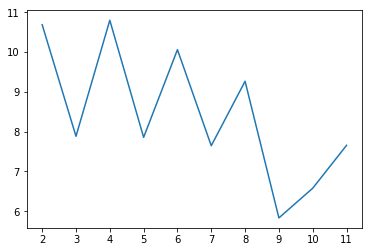

0
4


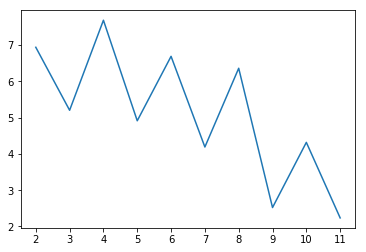

4


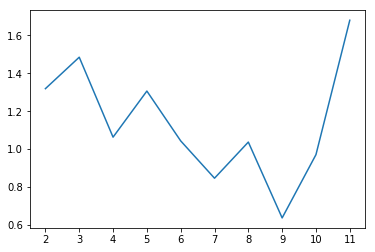

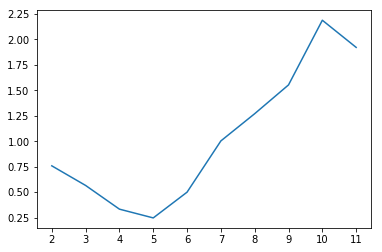

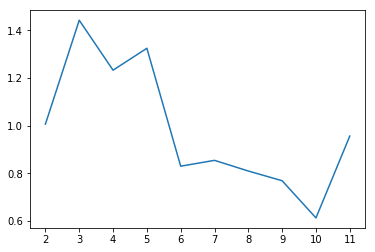

3


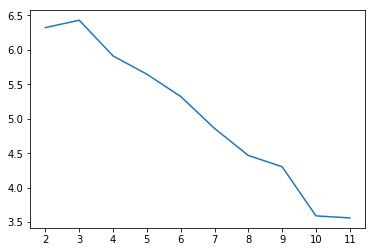

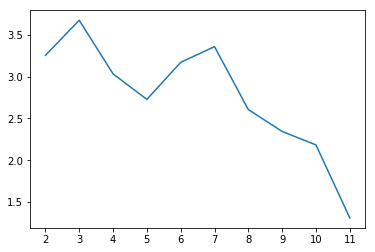

0
4


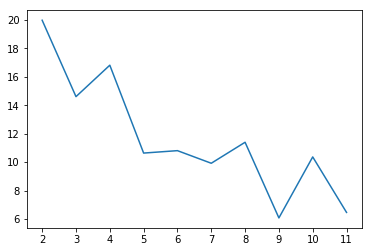

4


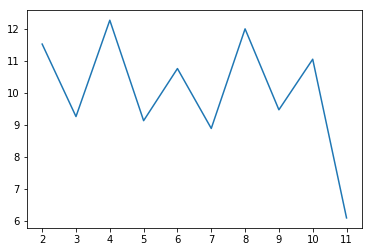

3


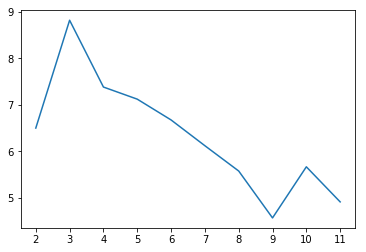

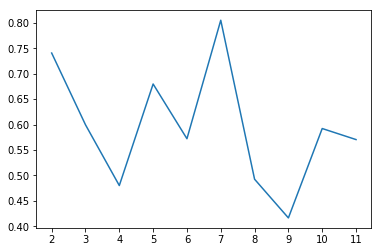

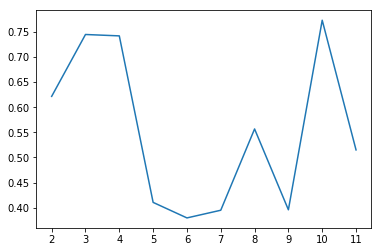

4


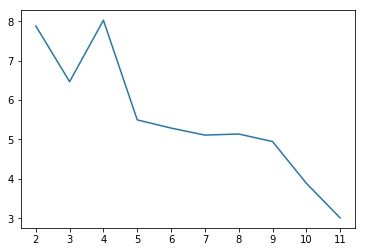

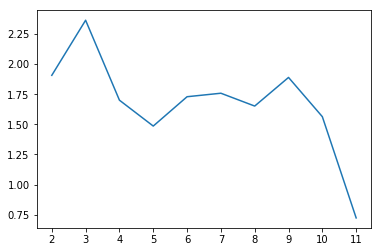

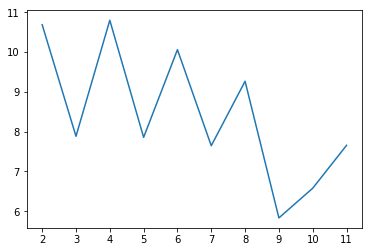

0
7


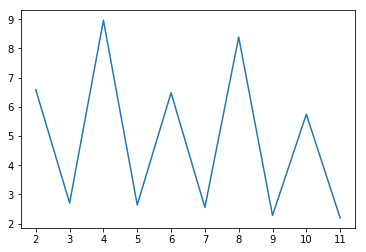

4


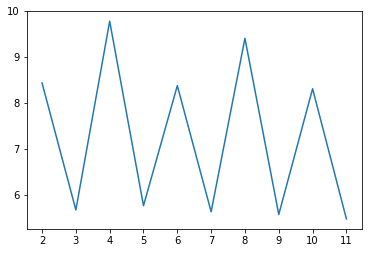

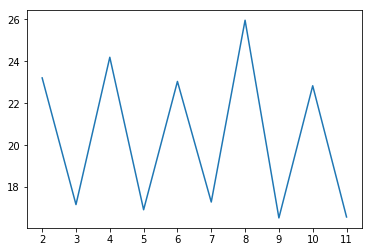

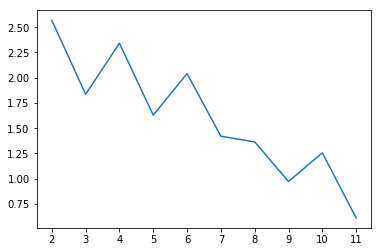

0
3


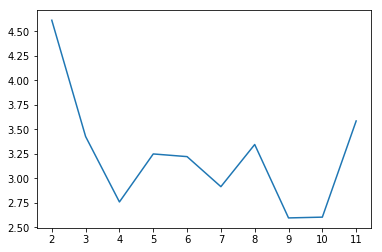

4


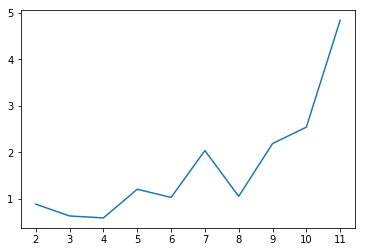

4


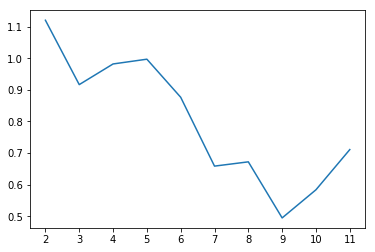

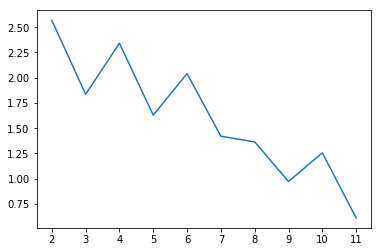

3


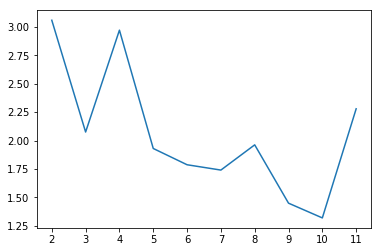

4


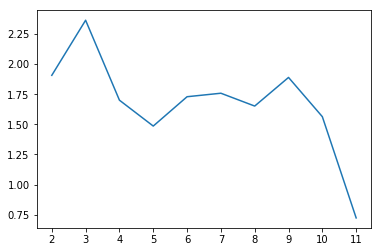

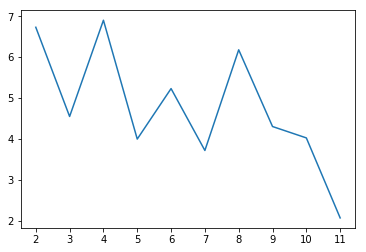

3


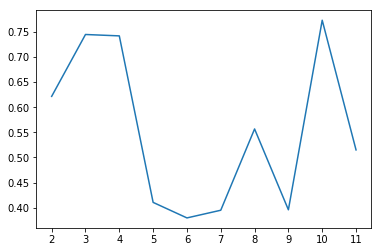

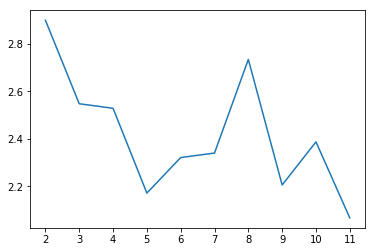

0
0
4


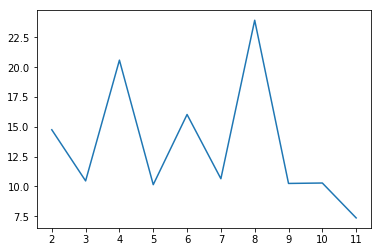

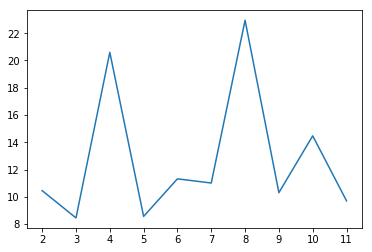

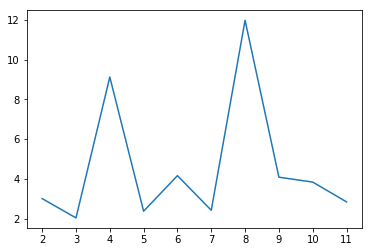

4


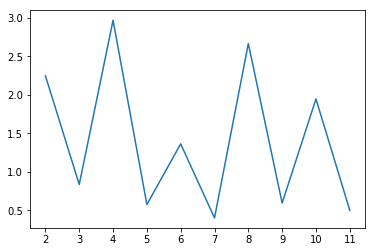

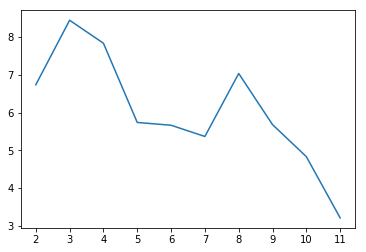

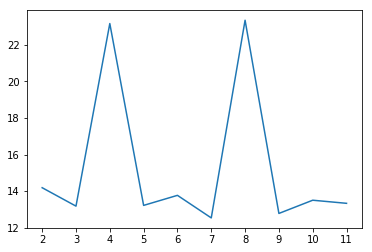

3


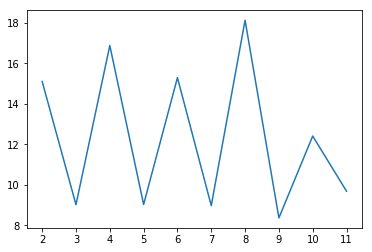

4


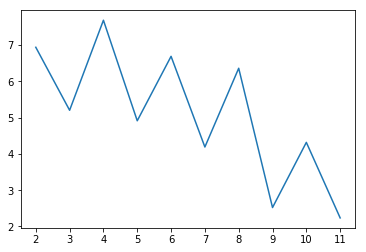

In [63]:
tags = ['rock', 'classical', 'heavy', 'jazz', 'opera','funk', 'funky', 'electronica', 'guitar', 'folk', 'fast', 'irish',
       'arabic', 'instrumental', 'spanish', 'orchestra', 'piano', 'celtic', 'woman', 'dance', 'techno', 'hip hop']
results_dict = {"tag": [], "song":[], "original_ts":[], "conf_original_ts":[], "estimated_ts":[],
                "conf_estimated_ts":[], "equal":[]}


for tag in tags:
    for timeSig, paths in getTrackCollection(tag, 3, 0.8).items():
        print(timeSig)
        if int(timeSig) == 0:
            continue
        for path in paths:
            
            audioInput, fs = load_audio(path['path'])
            spectrogram, db_spectrogram = compute_spectrogram(audioInput, fs)
            beats_frames, beats = get_beats_frames(audioInput, fs)
            ASM_dict = get_ASM(beats_frames, spectrogram)
            BSM = get_BSM(ASM_dict)
            tc, bar_candidates = get_candidates_list(BSM)
            plot_tc(tc)
            
            
            top_candidate = get_top_candidate(tc)
            confidence = get_confidence_top_candidate(tc)
            
            results_dict["tag"].append(tag)
            results_dict["song"].append(path['path'])
            results_dict["original_ts"].append(timeSig)
            results_dict["conf_original_ts"].append(path['timeSignatureConfidence'])
            results_dict["estimated_ts"].append(top_candidate)
            results_dict["conf_estimated_ts"].append(confidence)
            results_dict["equal"].append(int(timeSig) == int(top_candidate))

In [168]:
df_results = pd.DataFrame(results_dict)
print(df_results)

          tag                                               song original_ts  \
0        rock       c/lvx_nova-lvx_nova-01-contimune-233-262.mp3           4   
1        rock  0/rocket_city_riot-last_of_the_pleasure_seeker...           4   
2        rock  0/rocket_city_riot-last_of_the_pleasure_seeker...           4   
3        rock  c/mountain_mirrors-lunar_ecstasy-01-a_short_bu...           7   
4   classical  f/american_bach_soloists-j_s__bach_solo_cantat...           4   
5   classical  f/american_bach_soloists-j_s__bach_solo_cantat...           4   
6   classical  f/american_bach_soloists-j_s__bach_solo_cantat...           4   
7   classical  0/american_bach_soloists-j_s__bach__cantatas_v...           3   
8   classical  9/american_bach_soloists-heinrich_schutz__musi...           3   
9   classical  9/american_bach_soloists-heinrich_schutz__musi...           3   
10  classical  5/new_york_consort_of_viols-dances_and_canzona...           7   
11      heavy     f/pain_factor-8_second

In [174]:

print(sum(df_results['equal']==True) / len(df_results['equal']))


0.2916666666666667
